In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data = pd.read_csv("Preprocessed_Data.csv")
df = pd.DataFrame(data)

In [2]:
df.drop(['CRSDepTime', 'DepDel15',  'ArrTime', 'CRSArrTime', 'ArrDelayMinutes', 'OriginAirportID', 'DestAirportID', 'Quarter'
         , 'FlightDate', 'WindGustKmph', 'WindChillF'], axis = 1, inplace = True)

In [3]:
df.to_csv("Preprocessed_Data_Classification.csv", index=False)

In [4]:
data = pd.read_csv("Preprocessed_Data_Classification.csv")
df = pd.DataFrame(data)

In [5]:
df.head()

,Year,Month,DayofMonth,Origin,Dest,DepTime,DepDelayMinutes,ArrDel15,rounded_time,WindSpeedKmph,WindDirDegree,WeatherCode,precipMM,Visibility,Pressure,Cloudcover,DewPointF,tempF,Humidity
0,2016,1,1,SEA,JFK,741.0,0.0,0.0,1600,22.0,255.0,113.0,0.0,10.0,1015.0,0.0,32.0,41.0,74.0
1,2016,1,2,SEA,JFK,737.0,0.0,0.0,1600,19.0,248.0,113.0,0.0,10.0,1016.0,0.0,30.0,39.0,71.0
2,2016,1,3,SEA,JFK,743.0,0.0,0.0,1600,23.0,272.0,113.0,0.0,10.0,1009.0,46.0,31.0,40.0,69.0
3,2016,1,4,SEA,JFK,737.0,0.0,0.0,1600,28.0,342.0,116.0,0.0,10.0,1019.0,22.0,15.0,26.0,65.0
4,2016,1,5,SEA,JFK,708.0,0.0,0.0,1500,17.0,337.0,113.0,0.0,10.0,1035.0,0.0,14.0,27.0,61.0


In [6]:
df.shape

(1851436, 19)

In [7]:
X = df.drop('ArrDel15', axis=1, inplace=False)
y = df['ArrDel15']

In [8]:
X = pd.DataFrame(X, columns=[col for col in df.columns if col != 'ArrDel15'])
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_transformed = preprocessor.fit_transform(X)

y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.25, random_state=0)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("\nClassification Report:\n", report)

Accuracy: 0.9164561994041381

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95    365842
           1       0.89      0.69      0.78     97017

    accuracy                           0.92    462859
   macro avg       0.91      0.83      0.86    462859
weighted avg       0.91      0.92      0.91    462859



In [9]:
from collections import Counter

class_distribution = Counter(y_train)
print("Class distribution before SMOTE:")
for label, count in class_distribution.items():
    print(f"Class {label}: {count} ({(count / len(y_train)) * 100:.2f}%)")

Class distribution before SMOTE:
Class 0: 1097536 (79.04%)
Class 1: 291041 (20.96%)


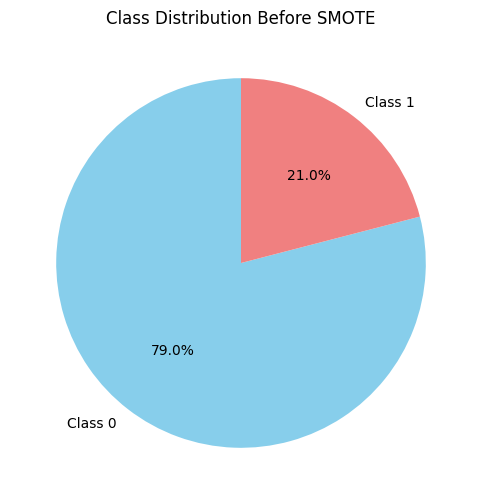

In [15]:
class_distribution = Counter(y_train)

labels = [f"Class {label}" for label in class_distribution.keys()]
sizes = list(class_distribution.values())

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title("Class Distribution Before SMOTE")
plt.show()

In [11]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=42, k_neighbors=5)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train.ravel())
X_test_res, y_test_res = sm.fit_resample(X_test_scaled, y_test.ravel())

pd.DataFrame(X_train_res).to_csv('X_train_res.csv', index=False)
pd.DataFrame(y_train_res).to_csv('y_train_res.csv', index=False)
pd.DataFrame(X_test_res).to_csv('X_test_res.csv', index=False)
pd.DataFrame(y_test_res).to_csv('y_test_res.csv', index=False)

pca = PCA(n_components=30)
X_train_reduced = pca.fit_transform(X_train_res)
X_test_reduced = pca.transform(X_test_res)

logistic = LogisticRegression(random_state=42)
logistic.fit(X_train_reduced, y_train_res)

y_pred = logistic.predict(X_test_reduced)

accuracy = accuracy_score(y_test_res, y_pred)
report = classification_report(y_test_res, y_pred, target_names=["Class 0", "Class 1"])

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

C:\Users\Rohit\AppData\Local\Temp\ipykernel_20316\3898218965.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train.ravel())
C:\Users\Rohit\AppData\Local\Temp\ipykernel_20316\3898218965.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_test_res, y_test_res = sm.fit_resample(X_test_scaled, y_test.ravel())


Logistic Regression Performance:
Accuracy: 0.8656
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.93      0.87    365842
     Class 1       0.92      0.80      0.86    365842

    accuracy                           0.87    731684
   macro avg       0.87      0.87      0.87    731684
weighted avg       0.87      0.87      0.87    731684



In [12]:
from collections import Counter

class_distribution_res = Counter(y_train_res)
print("Class distribution after SMOTE:")
for label_res, count_res in class_distribution_res.items():
    print(f"Class {label_res}: {count_res} ({(count_res / len(y_train_res)) * 100:.2f}%)")

Class distribution after SMOTE:
Class 0: 1097536 (50.00%)
Class 1: 1097536 (50.00%)


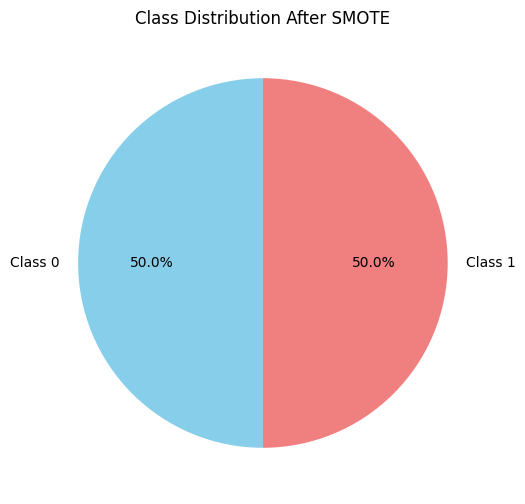

In [13]:
class_distribution_res = Counter(y_train_res)

labels_res = [f"Class {label_res}" for label_res in class_distribution_res.keys()]
sizes_res = list(class_distribution_res.values())

plt.figure(figsize=(6, 6))
plt.pie(sizes_res, labels=labels_res, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title("Class Distribution After SMOTE")
plt.show()

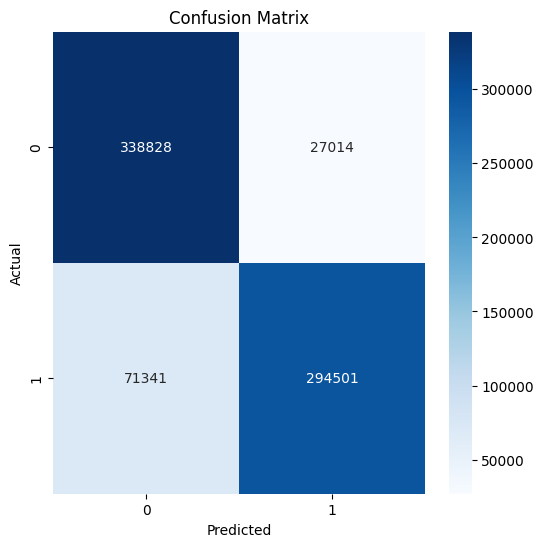

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_res, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()